#Time Series Analysis in Python

In [109]:
# some example data
import numpy as np
from numpy import (dot, identity, atleast_2d, atleast_1d, zeros)
from numpy.linalg import inv
from scipy import optimize
from scipy.stats import t, norm, ss as sumofsq
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import (lagmat, add_trend,
                _ar_transparams, _ar_invtransparams)
import statsmodels.tsa.base.tsa_model as tsbase
import statsmodels.base.model as base
from statsmodels.tools.decorators import (resettable_cache,
        cache_readonly, cache_writable)
from statsmodels.tools.numdiff import (approx_fprime, approx_hess,
        approx_hess_cs)
from statsmodels.tsa.kalmanf.kalmanfilter import KalmanFilter
import statsmodels.base.wrapper as wrap
from statsmodels.tsa.vector_ar import util
from statsmodels.graphics import utils
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.base.datetools import _index_date
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import acf, pacf
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

# make a VAR model
model = VAR(data)

In [110]:
results = model.fit(2)

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 20, Feb, 2016
Time:                     19:27:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.174
L1.realgdp         -0.279435         0.169663           -1.647           0.101
L1.realcons         0.675016         0.131285            5.142    

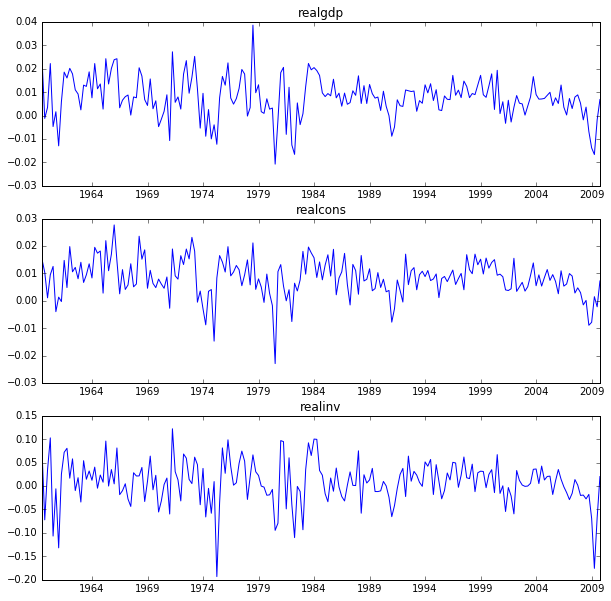

In [111]:
results.plot();

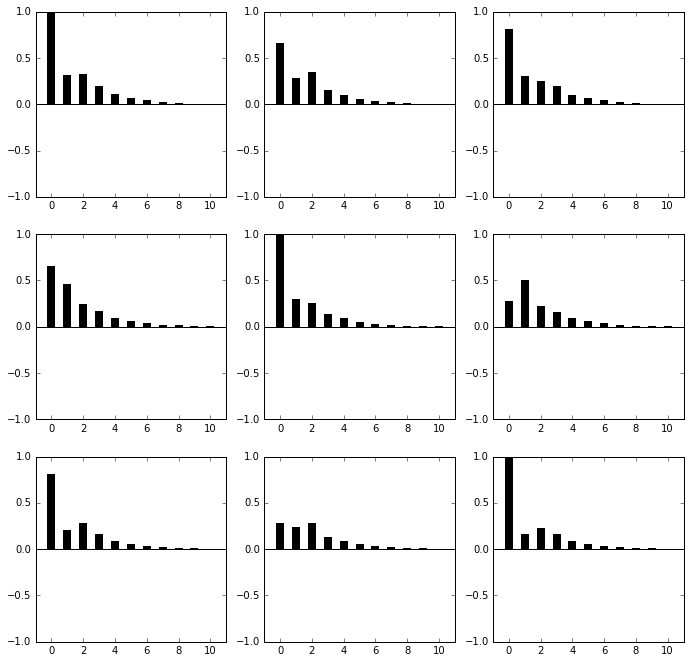

In [112]:
results.plot_acorr()

In [113]:
model.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -27.70       -27.65    9.358e-13       -27.68
1        -28.02      -27.82*    6.745e-13      -27.94*
2        -28.03       -27.66    6.732e-13       -27.88
3       -28.04*       -27.52   6.651e-13*       -27.83
4        -28.03       -27.36    6.681e-13       -27.76
5        -28.02       -27.19    6.773e-13       -27.69
6        -27.97       -26.98    7.147e-13       -27.57
7        -27.93       -26.79    7.446e-13       -27.47
8        -27.94       -26.64    7.407e-13       -27.41
9        -27.96       -26.50    7.280e-13       -27.37
10       -27.91       -26.30    7.629e-13       -27.26
11       -27.86       -26.09    8.076e-13       -27.14
12       -27.83       -25.91    8.316e-13       -27.05
13       -27.80       -25.73    8.594e-13       -26.96
14       -27.80       -25.57    8.627e-13       -26.90
15       -

{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 1}

In [114]:
results = model.fit(maxlags=15, ic='aic')

In [115]:
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)

array([[ 0.00616044,  0.00500006,  0.00916198],
       [ 0.00427559,  0.00344836, -0.00238478],
       [ 0.00416634,  0.0070728 , -0.01193629],
       [ 0.00557873,  0.00642784,  0.00147152],
       [ 0.00626431,  0.00666715,  0.00379567]])

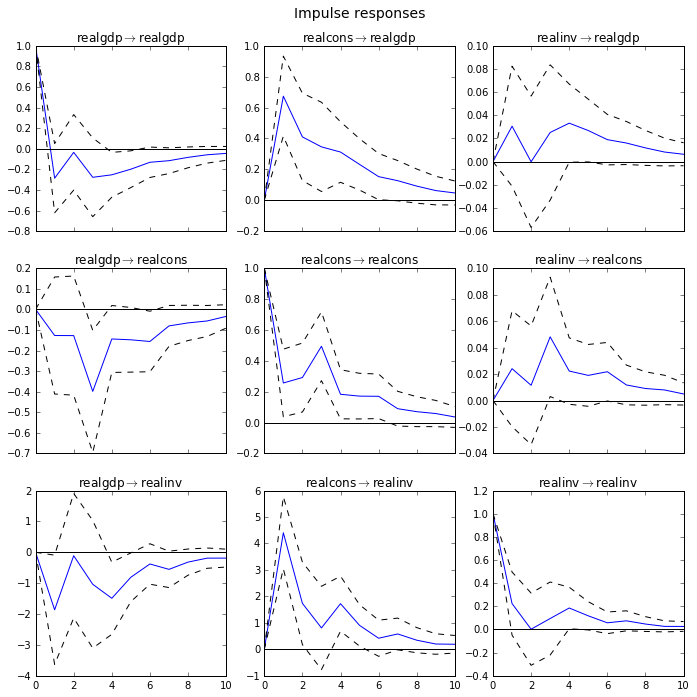

In [120]:
irf = results.irf(10)
irf.plot(orth=False)

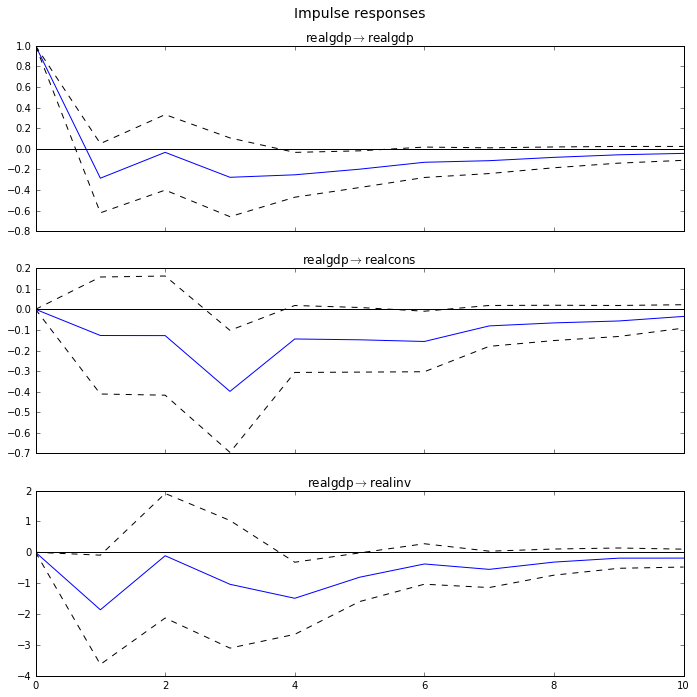

In [117]:
irf.plot(impulse='realgdp')

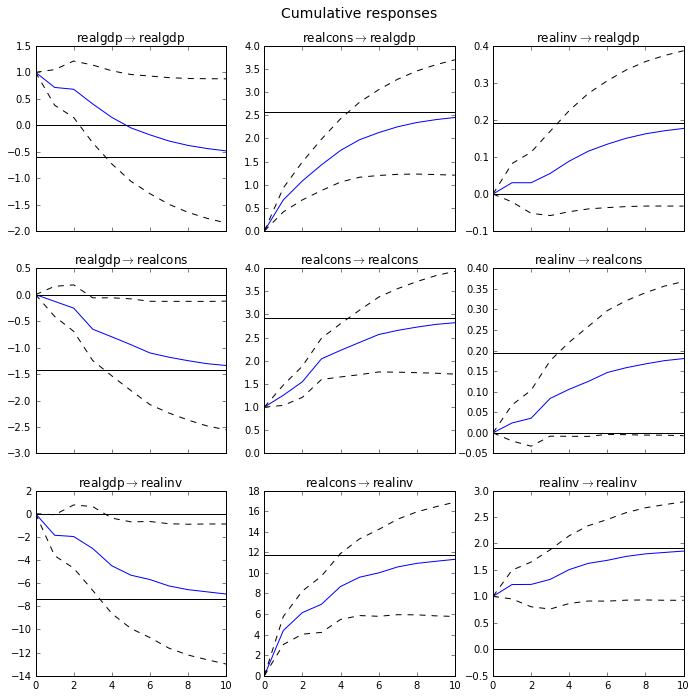

In [121]:
irf.plot_cum_effects(orth=False)

In [122]:
fevd = results.fevd(5)

fevd.summary()

FEVD for realgdp
      realgdp  realcons   realinv
0    1.000000  0.000000  0.000000
1    0.864889  0.129253  0.005858
2    0.816725  0.177898  0.005378
3    0.793647  0.197590  0.008763
4    0.777279  0.208127  0.014594

FEVD for realcons
      realgdp  realcons   realinv
0    0.359877  0.640123  0.000000
1    0.358767  0.635420  0.005813
2    0.348044  0.645138  0.006817
3    0.319913  0.653609  0.026478
4    0.317407  0.652180  0.030414

FEVD for realinv
      realgdp  realcons   realinv
0    0.577021  0.152783  0.270196
1    0.488158  0.293622  0.218220
2    0.478727  0.314398  0.206874
3    0.477182  0.315564  0.207254
4    0.466741  0.324135  0.209124




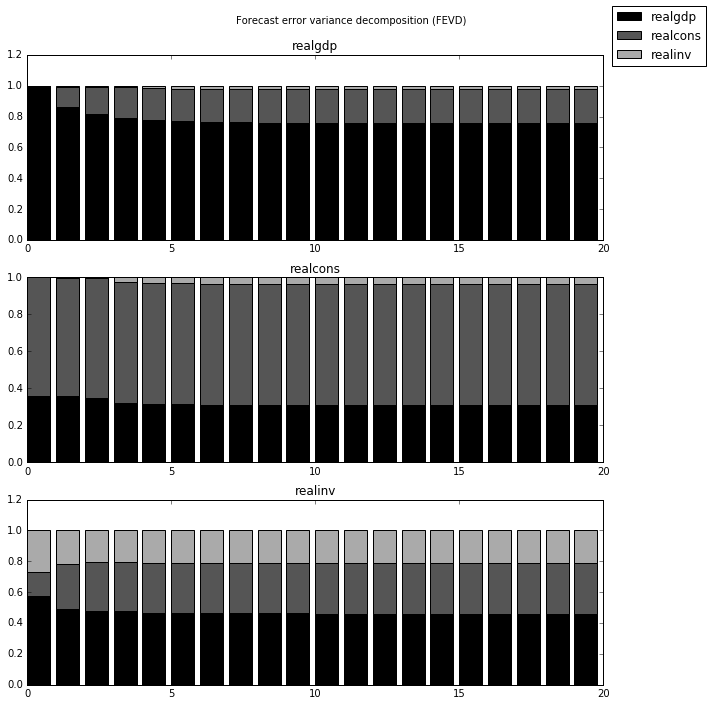

In [123]:
results.fevd(20).plot()

In [124]:
results.test_causality('realgdp', ['realinv', 'realcons'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         6.999888         2.114554            0.000  (6, 567)
H_0: ['realinv', 'realcons'] do not Granger-cause realgdp
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.1145543864563141,
 'df': (6, 567),
 'pvalue': 3.3805963773889358e-07,
 'signif': 0.05,
 'statistic': 6.9998875522543296}

In [125]:
data

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694
1960-09-30,0.001633,-0.003968,-0.005978
1960-12-31,-0.012906,0.001343,-0.131852
1961-03-31,0.005923,-0.000280,0.025244
1961-06-30,0.018535,0.014770,0.071834
1961-09-30,0.016032,0.004839,0.080453
